# CASA -> XDS image demo
The current authoritative version of the full image XDS 
schema can be found at https://docs.google.com/spreadsheets/d/1WW0Gl6z85cJVPgtdgW4dxucurHFa06OKGjgoK8OREFA/edit#gid=1719181934

# Only run the next cell if you haven't configured where to find casadata on your system. It will modify your .casarc file.

In [1]:
import socket, getpass

if not (socket.gethostname() == "orthanc" and getpass.getuser() == "dmehring"):
    import os, pkg_resources

    casa_data_dir = pkg_resources.resource_filename("casadata", "__data__")
    rc_file = open(os.path.expanduser("~/.casarc"), "a+")  # append mode
    rc_file.write("\nmeasures.directory: " + casa_data_dir)
    rc_file.close()

**Install packages**

In [2]:
if getpass.getuser != "dmehring":
    from importlib.metadata import version
    import os

    print("Installing/upgrading xradio")
    os.system("pip install --upgrade xradio pip")

Installing/upgrading xradio


**Imports**

In [3]:
import xradio
import graphviper

# These are the three API functions that are currently supported
from xradio.image import load_image, read_image, write_image

## Download image to be used

In [4]:
graphviper.utils.data.download("demo_simulated.im")

[2024-02-08 19:57:29,440]     INFO  graphviper:  File exists: demo_simulated.im 


## Convert CASA image to XDS

### Supported images, casa, FITS, zarr
Supported image formats that can be read
by this method are casacore, FITS, and zarr. Here "supported" means
some images in these formats are supported. The parameter space of
input image formats that has been investigated is still limited. For
example, aperture (*uv* plane) images are not yet supported, but given
their importance in applications like *feather* which make heavy use
of fourier transforms, support for them will likely be added sooner
rather than later. Note that images containing Taylor terms will also
be supported at some point.

### Always 5-D, time, polarization, frequency, l/u, m/v dimensions
Valid image XDSes always have five dimensions: time, frequency, polarization,
l (or u),
and m (or v). Images that have multiple (per-plane) beams will also have
a beam_param dimension. The dimensions will follow this ordering
in most, and maybe all, cases. That's still TBD.

###  Coordinates vs dimensions
Note that in xarray jargon, a dimension and a coordinate are
different constructs. Coordinates are "higher level" in that they are
always functions of dimensions. I think of dimensions as orthogonal
axes in a Cartesian coordinate system. They are essentially pixel coordinate
axes. Coordinates, however, do not
have to conform to this constraint, which is important for curved
surfaces like the sky. Think of RA and Dec, which are functions
of the two direction pixel coordinates, (l, m). So, xarray coordinates
are akin to CASA's world coordinates.

### read_image, create image xarray dataset (XDS)
The **read_image** function will convert an image in a supported format
to an image XDS (xarray.Dataset).

###  Output dask array chunksize specified as a dict to read_image()
The chunk size of the output dask pixel array can be specified using
a dictionary in which the supported keys are 'l' (corresponding to
the longitude like dimension), 'm' (corresponding to the latitude like
dimension), 'frequency' (corresponding to the spectral dimension), 'polarization'
(corresponding to the polarization dimension), and 'time'
(corresponding to the temporal dimension). The values correspond to
the chunk length along that axis. If any of these keys are absent, the
length of a chunk in that dimension will be equal to the number of
pixels along that axis. Specified keys for which there are no
corresponding axes in the CASA image are silently ignored. 'u' and 'v'
may be substituted for 'l' and 'm' which is useful in the case of
aperture (Fourier plane) images, when support for those has been added.

In [5]:
# polarization is not specified, so the length of the axis in this dimension
# is equal to the number of pixels on the polarization axis, which is 4.
imname = "demo_simulated.im"

xds = read_image(infile=imname, chunks={"l": 40, "m": 20, "frequency": 5})
xds

ary shape (1, 4, 50, 200, 100)
xds dims Frozen({'time': 1, 'polarization': 4, 'frequency': 50, 'l': 200, 'm': 100})
dimorder ['time', 'polarization', 'frequency', 'l', 'm']
xds <xarray.Dataset>
Dimensions:          (time: 1, polarization: 4, frequency: 50, l: 200, m: 100)
Coordinates:
  * time             (time) float64 5.154e+04
  * polarization     (polarization) <U1 'I' 'Q' 'U' 'V'
  * frequency        (frequency) float64 1.415e+09 1.415e+09 ... 1.415e+09
    velocity         (frequency) float64 1.146e+06 1.146e+06 ... 1.136e+06
  * l                (l) float64 0.02909 0.0288 0.02851 ... -0.02851 -0.0288
  * m                (m) float64 -0.01454 -0.01425 -0.01396 ... 0.01396 0.01425
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
Data variables:
    *empty*
xda <xarray.DataArray 'sky' (time: 1, polarization: 4, frequency: 50, l: 200, m: 100)>
dask.array<transpose, shape=(1, 4, 50

<xarray.Dataset>
Dimensions:          (time: 1, polarization: 4, frequency: 50, l: 200, m: 100,
                      beam_param: 3)
Coordinates:
  * time             (time) float64 5.154e+04
  * polarization     (polarization) <U1 'I' 'Q' 'U' 'V'
  * frequency        (frequency) float64 1.415e+09 1.415e+09 ... 1.415e+09
    velocity         (frequency) float64 1.146e+06 1.146e+06 ... 1.136e+06
  * l                (l) float64 0.02909 0.0288 0.02851 ... -0.02851 -0.0288
  * m                (m) float64 -0.01454 -0.01425 -0.01396 ... 0.01396 0.01425
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
Data variables:
    sky              (time, polarization, frequency, l, m) float32 dask.array<chunksize=(1, 4, 5, 40, 20), meta=np.ndarray>
    mask0            (time, polarization, frequency, l, m) bool dask.array<chunksize=(1, 4, 5, 40, 20), meta=np.ndarray>
    beam             (time, polarization, frequency, beam_param) float64 dask.array<chunksize=(1, 4, 50, 3), meta=np.ndarray>
Attributes:
    direction:        {'reference': {'frame': 'FK5', 'type': 'sky_coord', 'eq...
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'elli...
    obsdate:          {'type': 'time', 'scale': 'UTC', 'units': 'd', 'value':...
    pointing_center:  {'value': array([0., 0.]), 'initial': True}
    observer:         Karl Jansky
    object_name:      
    user:             {}
    active_mask:      mask0
    description:      None
    history:          <xarray.Dataset>\nDimensions:    (row: 15, TIME: 15, PR...

##  Data Variables

### Data Variable: Pixel Values

The image pixel values are contained in the sky data variable.

In [6]:
xds.sky

<xarray.DataArray 'sky' (time: 1, polarization: 4, frequency: 50, l: 200, m: 100)>
dask.array<transpose, shape=(1, 4, 50, 200, 100), dtype=float32, chunksize=(1, 4, 5, 40, 20), chunktype=numpy.ndarray>
Coordinates:
  * time             (time) float64 5.154e+04
  * polarization     (polarization) <U1 'I' 'Q' 'U' 'V'
  * frequency        (frequency) float64 1.415e+09 1.415e+09 ... 1.415e+09
    velocity         (frequency) float64 1.146e+06 1.146e+06 ... 1.136e+06
  * l                (l) float64 0.02909 0.0288 0.02851 ... -0.02851 -0.0288
  * m                (m) float64 -0.01454 -0.01425 -0.01396 ... 0.01396 0.01425
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
Attributes:
    image_type:  Intensity
    units:       Jy/beam

###  Data Variable: Masks

**WARNING: 
The meaning of xradio image mask values follows the numpy masked array
convention which is opposite to CASA, ie True means the pixel is good, 
False means it is bad**

The active mask can be found in the xds 'active_mask' attr (more on attributes later). An empty string indicates that no mask is active; that is, all pixels are considered "good". Our example
image does have a mask, and it is stored in the mask0 data variable.

In [7]:
active_mask = xds.attrs["active_mask"]
active_mask

'mask0'

Mask values are stored in the xds data variable named for the mask

In [8]:
xds[active_mask]

<xarray.DataArray 'mask0' (time: 1, polarization: 4, frequency: 50, l: 200,
                           m: 100)>
dask.array<logical_not, shape=(1, 4, 50, 200, 100), dtype=bool, chunksize=(1, 4, 5, 40, 20), chunktype=numpy.ndarray>
Coordinates:
  * time             (time) float64 5.154e+04
  * polarization     (polarization) <U1 'I' 'Q' 'U' 'V'
  * frequency        (frequency) float64 1.415e+09 1.415e+09 ... 1.415e+09
    velocity         (frequency) float64 1.146e+06 1.146e+06 ... 1.136e+06
  * l                (l) float64 0.02909 0.0288 0.02851 ... -0.02851 -0.0288
  * m                (m) float64 -0.01454 -0.01425 -0.01396 ... 0.01396 0.01425
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
Attributes:
    image_type:  Mask

Or, via XDS 'dot' notation

In [9]:
xds.mask0

<xarray.DataArray 'mask0' (time: 1, polarization: 4, frequency: 50, l: 200,
                           m: 100)>
dask.array<logical_not, shape=(1, 4, 50, 200, 100), dtype=bool, chunksize=(1, 4, 5, 40, 20), chunktype=numpy.ndarray>
Coordinates:
  * time             (time) float64 5.154e+04
  * polarization     (polarization) <U1 'I' 'Q' 'U' 'V'
  * frequency        (frequency) float64 1.415e+09 1.415e+09 ... 1.415e+09
    velocity         (frequency) float64 1.146e+06 1.146e+06 ... 1.136e+06
  * l                (l) float64 0.02909 0.0288 0.02851 ... -0.02851 -0.0288
  * m                (m) float64 -0.01454 -0.01425 -0.01396 ... 0.01396 0.01425
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
Attributes:
    image_type:  Mask

###  Data Variable: Multiple Beams

For a multi (per-plane) beam image, beams are stored in the 'beam' data variable so an XDS selection results in the correct beams being selected. If the image does not have multiple beams, there is instead an xds.beam attribute. If the image has a single beam, it is stored there in a CASA-like beam dictionary {major, minor, pa}. If the image has no beam then xds.attrs['beam']=None. The image in this demo has multiple beams.

In [10]:
xds.beam

<xarray.DataArray 'beam' (time: 1, polarization: 4, frequency: 50, beam_param: 3)>
dask.array<array, shape=(1, 4, 50, 3), dtype=float64, chunksize=(1, 4, 50, 3), chunktype=numpy.ndarray>
Coordinates:
  * time          (time) float64 5.154e+04
  * polarization  (polarization) <U1 'I' 'Q' 'U' 'V'
  * frequency     (frequency) float64 1.415e+09 1.415e+09 ... 1.415e+09
    velocity      (frequency) float64 1.146e+06 1.146e+06 ... 1.136e+06
  * beam_param    (beam_param) <U5 'major' 'minor' 'pa'
Attributes:
    units:    rad

All beam parameters are stored in a single array. The final dimension in the beam array is 'beam_param'. The length of this axis is always three. The three "coordinate" labels for that axis are for major axis, minor axis, and position angle. The values on the beam_param axis are labeled to allow easy selection using xarray selection methods. For example, one can easily select only the major axis values. Normally, we don't want to drop degenerate dimensions produced by selections, so to avoid that we put the value being selected in square brackets (more on selecting data later).

In [11]:
xds.beam.sel(beam_param=["major"])

<xarray.DataArray 'beam' (time: 1, polarization: 4, frequency: 50, beam_param: 1)>
dask.array<getitem, shape=(1, 4, 50, 1), dtype=float64, chunksize=(1, 4, 50, 1), chunktype=numpy.ndarray>
Coordinates:
  * time          (time) float64 5.154e+04
  * polarization  (polarization) <U1 'I' 'Q' 'U' 'V'
  * frequency     (frequency) float64 1.415e+09 1.415e+09 ... 1.415e+09
    velocity      (frequency) float64 1.146e+06 1.146e+06 ... 1.136e+06
  * beam_param    (beam_param) <U5 'major'
Attributes:
    units:    rad

## Coordinates

### Accessing Coordinates

Coordinate are stored as xarray DataArrays. A coordinate may have
attributes that provide metadata pertaining to the coordinate.

You can explicitly indicate a coordinate is a by referring to the coords
dict of the xds. This may make your code more readable. However you can
also refer to them using the 'dot' notation, and because a coordinate
sometimes has the same name as a dimension (and so is called a dimension
coordinate), and because when indexing dimensions you always use the
'dot' notation, using the 'dot' notation for coordinates as well is
probably ok from a best practice point of view. So, my opinion is
either-or.

In [12]:
xds.coords["time"]
# or
xds.time
# or
xds["time"]

<xarray.DataArray 'time' (time: 1)>
array([51544.])
Coordinates:
  * time     (time) float64 5.154e+04
Attributes:
    type:     time
    scale:    UTC
    units:    d
    format:   MJD

In [13]:
xds.polarization

<xarray.DataArray 'polarization' (polarization: 4)>
array(['I', 'Q', 'U', 'V'], dtype='<U1')
Coordinates:
  * polarization  (polarization) <U1 'I' 'Q' 'U' 'V'

In [14]:
xds.frequency

<xarray.DataArray 'frequency' (frequency: 50)>
array([1.414975e+09, 1.414976e+09, 1.414977e+09, 1.414978e+09, 1.414979e+09,
       1.414980e+09, 1.414981e+09, 1.414982e+09, 1.414983e+09, 1.414984e+09,
       1.414985e+09, 1.414986e+09, 1.414987e+09, 1.414988e+09, 1.414989e+09,
       1.414990e+09, 1.414991e+09, 1.414992e+09, 1.414993e+09, 1.414994e+09,
       1.414995e+09, 1.414996e+09, 1.414997e+09, 1.414998e+09, 1.414999e+09,
       1.415000e+09, 1.415001e+09, 1.415002e+09, 1.415003e+09, 1.415004e+09,
       1.415005e+09, 1.415006e+09, 1.415007e+09, 1.415008e+09, 1.415009e+09,
       1.415010e+09, 1.415011e+09, 1.415012e+09, 1.415013e+09, 1.415014e+09,
       1.415015e+09, 1.415016e+09, 1.415017e+09, 1.415018e+09, 1.415019e+09,
       1.415020e+09, 1.415021e+09, 1.415022e+09, 1.415023e+09, 1.415024e+09])
Coordinates:
  * frequency  (frequency) float64 1.415e+09 1.415e+09 ... 1.415e+09 1.415e+09
    velocity   (frequency) float64 1.146e+06 1.146e+06 ... 1.136e+06 1.136e+06
Attributes:
    rest_frequency:  {'type': 'quantity', 'units': 'Hz', 'value': 1420405751....
    type:            frequency
    units:           Hz
    frame:           LSRK
    wave_unit:       mm
    crval:           1415000000.0
    cdelt:           1000.0

In [15]:
xds.velocity

<xarray.DataArray 'velocity' (frequency: 50)>
array([1146220.665937  , 1146009.60479647, 1145798.54365594,
       1145587.48251538, 1145376.42137485, 1145165.36023431,
       1144954.29909378, 1144743.23795325, 1144532.17681269,
       1144321.11567215, 1144110.05453162, 1143898.99339109,
       1143687.93225053, 1143476.87111   , 1143265.80996946,
       1143054.74882893, 1142843.6876884 , 1142632.62654784,
       1142421.56540731, 1142210.50426677, 1141999.44312624,
       1141788.38198568, 1141577.32084515, 1141366.25970461,
       1141155.19856408, 1140944.13742352, 1140733.07628299,
       1140522.01514246, 1140310.95400192, 1140099.89286139,
       1139888.83172083, 1139677.7705803 , 1139466.70943977,
       1139255.64829923, 1139044.58715867, 1138833.52601814,
       1138622.46487761, 1138411.40373707, 1138200.34259654,
       1137989.28145598, 1137778.22031545, 1137567.15917492,
       1137356.09803438, 1137145.03689382, 1136933.97575329,
       1136722.91461276, 1136511.85347223, 1136300.79233169,
       1136089.73119113, 1135878.6700506 ])
Coordinates:
  * frequency  (frequency) float64 1.415e+09 1.415e+09 ... 1.415e+09 1.415e+09
    velocity   (frequency) float64 1.146e+06 1.146e+06 ... 1.136e+06 1.136e+06
Attributes:
    doppler_type:  RADIO
    units:         m/s
    type:          doppler

For astronomical images, the longitude-like (eg, RA) and latitude-like
(eg, Dec) coordinates are functions of both the *l* and *m* dimensions
and so are 2-D arrays to properly account for sky curvature. These
values are generally in radians. The coordinate name will depend on what
is represented, eg it could be galactic_longitude for an image that uses
galactic coordinates.

In [16]:
xds.right_ascension

<xarray.DataArray 'right_ascension' (l: 200, m: 100)>
array([[0.029096  , 0.02909588, 0.02909576, ..., 0.02909564, 0.02909576,
        0.02909588],
       [0.02880496, 0.02880484, 0.02880472, ..., 0.02880461, 0.02880472,
        0.02880484],
       [0.02851392, 0.0285138 , 0.02851369, ..., 0.02851357, 0.02851369,
        0.0285138 ],
       ...,
       [6.25496242, 6.25496254, 6.25496265, ..., 6.25496277, 6.25496265,
        6.25496254],
       [6.25467138, 6.2546715 , 6.25467162, ..., 6.25467173, 6.25467162,
        6.2546715 ],
       [6.25438034, 6.25438047, 6.25438058, ..., 6.2543807 , 6.25438058,
        6.25438047]])
Coordinates:
  * l                (l) float64 0.02909 0.0288 0.02851 ... -0.02851 -0.0288
  * m                (m) float64 -0.01454 -0.01425 -0.01396 ... 0.01396 0.01425
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425

In [17]:
xds.declination

<xarray.DataArray 'declination' (l: 200, m: 100)>
array([[-0.01454492, -0.014254  , -0.01396309, ...,  0.01367217,
         0.01396309,  0.014254  ],
       [-0.01454492, -0.014254  , -0.01396309, ...,  0.01367217,
         0.01396309,  0.014254  ],
       [-0.01454492, -0.014254  , -0.01396309, ...,  0.01367217,
         0.01396309,  0.014254  ],
       ...,
       [-0.01454492, -0.014254  , -0.01396309, ...,  0.01367217,
         0.01396309,  0.014254  ],
       [-0.01454492, -0.014254  , -0.01396309, ...,  0.01367217,
         0.01396309,  0.014254  ],
       [-0.01454492, -0.014254  , -0.01396309, ...,  0.01367217,
         0.01396309,  0.014254  ]])
Coordinates:
  * l                (l) float64 0.02909 0.0288 0.02851 ... -0.02851 -0.0288
  * m                (m) float64 -0.01454 -0.01425 -0.01396 ... 0.01396 0.01425
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425

### Coordinate Attributes

All coordinates, except polarization, have attributes, which are metadata that describe the coordinate. These are dictionaries that are stored in the attrs field of the coordinate.

#### attrs is a dict and accessible via the attrs field

In [18]:
xds.time.attrs

{'type': 'time', 'scale': 'UTC', 'units': 'd', 'format': 'MJD'}

####  prefer to access attrs via the explicit attrs field rather than dot notation
You can again access attributes with the 'dot' notation, but because
attributes can be numerous, I generally indicate explicitly that I'm
referring to an attribute by explicitly naming the attrs field. IMO this
is best practice when referring to attributes. It's a bit easier to 
distinguish coordinate attributes using the 'dot' notation than it is
to distinguish dataset attributes (discussed later), but for
consistency I like to explicitly refer to the attrs field in both cases.

In [19]:
# So I don't recommend this, even though it is valid
xds.time.units
# I instead recommend this
xds.time.attrs["units"]

'd'

In [20]:
xds.frequency.attrs

{'rest_frequency': {'type': 'quantity',
  'units': 'Hz',
  'value': 1420405751.7860003},
 'type': 'frequency',
 'units': 'Hz',
 'frame': 'LSRK',
 'wave_unit': 'mm',
 'crval': 1415000000.0,
 'cdelt': 1000.0}

In [21]:
xds.velocity.attrs

{'doppler_type': 'RADIO', 'units': 'm/s', 'type': 'doppler'}

For astronomical images, the longitude-like and latitude-like coordinate have both seperable attributes and shared attributes. The separable attributes are stored with the coordinate. The shared attributes are stored in the 'direction' attribute of the xds.

In [22]:
xds.right_ascension.attrs

{}

In [23]:
xds.declination.attrs

{}

##  Dateset Level Attributes

Metadata that apply to the dataset as a whole are stored in dataset
level attributes. Most of these come right from the CASA image
metadata.

In [24]:
xds.attrs.keys()

dict_keys(['direction', 'telescope', 'obsdate', 'pointing_center', 'observer', 'object_name', 'user', 'active_mask', 'description', 'history'])

This is the shared direction coordinate metadata at the xds level. Note that system='J2000' in the CASA image maps to system='FK5' (the frame in astropy speak) and equinox='J2000' in the xds image. This is how astropy requires these details to be provided.

In [25]:
xds.attrs["direction"]

{'reference': {'frame': 'FK5',
  'type': 'sky_coord',
  'equinox': 'J2000',
  'value': [0.0, 0.0],
  'cdelt': [-0.0002908882086657216, 0.0002908882086657216],
  'units': ['rad', 'rad']},
 'latpole': {'value': 0.0, 'units': 'rad', 'type': 'quantity'},
 'longpole': {'value': 3.141592653589793, 'units': 'rad', 'type': 'quantity'},
 'pc': array([[1., 0.],
        [0., 1.]]),
 'projection_parameters': array([0., 0.]),
 'projection': 'SIN'}

In [26]:
xds.attrs["telescope"]

{'name': 'ALMA',
 'position': {'type': 'position',
  'ellipsoid': 'GRS80',
  'units': ['rad', 'rad', 'm'],
  'value': [-1.1825465955049892, -0.3994149869262738, 6379946.01326443]}}

In [27]:
xds.attrs["observer"]

'Karl Jansky'

In [28]:
xds.attrs["obsdate"]

{'type': 'time',
 'scale': 'UTC',
 'units': 'd',
 'value': 51544.00000000116,
 'format': 'MJD'}

In [29]:
xds.attrs["pointing_center"]

{'value': array([0., 0.]), 'initial': True}

In [30]:
xds.attrs["object_name"]

''

#### Cannot set attr using dot notation
xarray does not permit setting of attributes using 'dot' notation.

In [31]:
try:
    xds.object_name = "SgrB2"
    print(
        "Wow! You have superhuman python powers. We would like to hire you as an "
        "assistant superhero python developer with the Avengers!"
    )
except Exception as e:
    print(e)
    print(
        "\nAww. You only have regular human python powers. Thanks for applying for a "
        "position with the Avengers, but we have no use for your feeble regular human "
        "python powers at this time."
    )

cannot set attribute 'object_name' on a 'Dataset' object. Use __setitem__ styleassignment (e.g., `ds['name'] = ...`) instead of assigning variables.

Aww. You only have regular human python powers. Thanks for applying for a position with the Avengers, but we have no use for your feeble regular human python powers at this time.


In [32]:
xds.attrs["object_name"] = "SgrB2"
xds.attrs["object_name"]

'SgrB2'

#### User attr dictionary
The 'user' attribute is for user specified metadata. This is also where metadata from the CASA image 'miscinfo' dictionary are written.

In [33]:
xds.attrs["user"]["phone"] = 123456
xds.attrs["user"]

{'phone': 123456}

In [34]:
xds.attrs["description"]  # this image has no description

In [35]:
xds.attrs["description"] = "my way cool pretend image"
xds.attrs["description"]

'my way cool pretend image'

The history is currently stored as an xarray Dataset but the specific
format will likely change once a format that can be used for both
images and MSes has been specified

In [36]:
xds.attrs["history"]

<xarray.Dataset>
Dimensions:    (row: 15, TIME: 15, PRIORITY: 15, MESSAGE: 15, LOCATION: 15)
Coordinates:
    OBJECT_ID  (row) <U1 '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
  * TIME       (TIME) float64 5.19e+09 5.19e+09 5.19e+09 ... 5.19e+09 5.19e+09
  * PRIORITY   (PRIORITY) <U4 'INFO' 'INFO' 'INFO' ... 'INFO' 'INFO' 'INFO'
  * MESSAGE    (MESSAGE) <U150 "Created Paged image 'demo.im' of shape [200, ...
  * LOCATION   (LOCATION) <U27 '::ImageFactory::createImage' ... '::image::pu...
Dimensions without coordinates: row
Data variables:
    *empty*
Attributes:
    column_descriptions:  {'TIME': {'valueType': 'double', 'dataManagerType':...
    info:                 {'type': 'Log message', 'subType': '', 'readme': 'R...
    bad_cols:             []

In [37]:
xds.attrs["history"].TIME

<xarray.DataArray 'TIME' (TIME: 15)>
array([5.189594e+09, 5.189594e+09, 5.189594e+09, 5.189594e+09, 5.189594e+09,
       5.189595e+09, 5.189595e+09, 5.189614e+09, 5.189614e+09, 5.189614e+09,
       5.189614e+09, 5.189934e+09, 5.189934e+09, 5.189963e+09, 5.189963e+09])
Coordinates:
  * TIME     (TIME) float64 5.19e+09 5.19e+09 5.19e+09 ... 5.19e+09 5.19e+09

In [38]:
xds.attrs["history"].MESSAGE

<xarray.DataArray 'MESSAGE' (MESSAGE: 15)>
array(["Created Paged image 'demo.im' of shape [200, 100, 50, 4] with float valued pixels.",
       'Ran ia.fromshape',
       'ia.fromshape(outfile="demo.im", shape=[200,100,50,4], csys={...}, linear=false, overwrite=false, log=true, type="f")',
       'Ran ia.addnoise',
       'ia.addnoise(type="normal", pars=[0.000000,1.000000], region={...}, zeroit=false, seeds=[])',
       'Ran ia.subimage',
       'ia.subimage(outfile="demo1.im", region="", mask="demo.im > 0", dropdeg=false, overwrite=false, list=true, stretch=false, wantreturn=true, keepaxes=[])',
       'Ran ia.setrestoringbeam',
       'ia.setrestoringbeam(major="5arcmin", minor="4arcmin", pa="20deg", beam={...}, remove=false, log=true, channel=0, polarization=0, imagename="")',
       'Ran ia.setrestoringbeam',
       'ia.setrestoringbeam(major="5arcmin", minor="4arcmin", pa="10deg", beam={...}, remove=false, log=true, channel=1, polarization=1, imagename="")',
       'Ran ia.setbrightnessunit', 'ia.setbrightnessunit(unit="Jy/beam")',
       'Ran ia.putchunk',
       'ia.putchunk(pixels="[...]", blc=[-1], inc=[1], list=false, locking=true, replicate=false)'],
      dtype='<U150')
Coordinates:
  * MESSAGE  (MESSAGE) <U150 "Created Paged image 'demo.im' of shape [200, 10...

##  Bonus Section: Measures in xradio
xradio will support a few types of measures (and the image schema will be
updated to support those very soon). A measure will have a type key indicating
what type of measure it is. There will be a quantity type

In [39]:
{"type": "quantity", "value": 4, "units": "m"}

{'type': 'quantity', 'value': 4, 'units': 'm'}

time type

In [40]:
{"type": "time", "value": 1697666092, "units": "s", "scale": "utc", "format": "unix"}

{'type': 'time',
 'value': 1697666092,
 'units': 's',
 'scale': 'utc',
 'format': 'unix'}

spectral_coord type

In [41]:
{"type": "spectral_coord", "value": 1.415e9, "units": ["Hz"], "frame": "lsrk"}

{'type': 'spectral_coord',
 'value': 1415000000.0,
 'units': ['Hz'],
 'frame': 'lsrk'}

sky_coord type

In [42]:
{"type": "sky_coord", "value": [1.5, -0.4], "units": "rad", "frame": "FK5"}

{'type': 'sky_coord', 'value': [1.5, -0.4], 'units': 'rad', 'frame': 'FK5'}

earth_location type

In [43]:
{
    "type": "earch_location",
    "value": [-1.1825466, -0.3994149, 6379946],
    "units": ["rad", "rad", "m"],
    "ellipsoid": "GRS80",
}

{'type': 'earch_location',
 'value': [-1.1825466, -0.3994149, 6379946],
 'units': ['rad', 'rad', 'm'],
 'ellipsoid': 'GRS80'}

and doppler type

In [44]:
{"type": "doppler", "value": 60000, "units": "m/s", "doppler_type": "radio"}

{'type': 'doppler', 'value': 60000, 'units': 'm/s', 'doppler_type': 'radio'}

##  Data Selection

###  Using numpy indexing (but don't do this)

Basic numpy indexing and slicing can be used to get values, although this method is the least recommended since it assumes the axis ordering. Better ways are discussed later.

####  values returns a numpy array
'values' returns a numpy array. Note that with the specified selection below, the output polarization axis will be degenerate. 

#### Carry along all dimensions when selecting to end up with a valid image XDS
The degenerate axis is kept by specifying the corresponding axis selection as [0], rather than 0. In the latter case, the axis will be dropped. In general, we want to carry all dimensions along; an image XDS pixel and mask data variables should always be five dimensional to avoid any ambiguity of dimension number to coordinate mapping.

In [45]:
vals = xds.sky[:, [0], 8:9, 5:7, 8:9].values
vals

array([[[[[ 0.39568448],
          [-0.94448763]]]]], dtype=float32)

####  compute() returns an xarray.DataArray
Calling compute() returns an xarray DataArray. Similar to above, if the
polarization axis selection is not enclosed in [], the pol dimension will
be dropped in the output DataArray.

In [46]:
xda = xds.sky[:, [0], 8:9, 5:7, 8:9].compute()
xda

<xarray.DataArray 'sky' (time: 1, polarization: 1, frequency: 1, l: 2, m: 1)>
array([[[[[ 0.39568448],
          [-0.94448763]]]]], dtype=float32)
Coordinates:
  * time             (time) float64 5.154e+04
  * polarization     (polarization) <U1 'I'
  * frequency        (frequency) float64 1.415e+09
    velocity         (frequency) float64 1.145e+06
  * l                (l) float64 0.02763 0.02734
  * m                (m) float64 -0.01222
    right_ascension  (l, m) float64 0.02764 0.02735
    declination      (l, m) float64 -0.01222 -0.01222
Attributes:
    image_type:  Intensity
    units:       Jy/beam

#### But don't use numpy selection syntax, instead select by dimensions and/or coordinates
In general, numpy selection syntax is discouraged. It is preferred instead that selection make use of xarray style selection which is based on dimension and coordinate names and labels.

 ### Using `isel()`

One can select xarray data using indexing by dimension names.
This can be done at the xarray.DataArray level, or the xarray.Dataset level.

For example, to select stokes I from the first two frequency planes in the Dataset using integer array indices. Remember the numpy selection syntax used to preserve dimensionality when there is a degenerate axis in the output? That applies here as well

In [47]:
freq_0_1 = xds.isel({"frequency": slice(0, 2), "polarization": [0]})
freq_0_1

<xarray.Dataset>
Dimensions:          (time: 1, polarization: 1, frequency: 2, l: 200, m: 100,
                      beam_param: 3)
Coordinates:
  * time             (time) float64 5.154e+04
  * polarization     (polarization) <U1 'I'
  * frequency        (frequency) float64 1.415e+09 1.415e+09
    velocity         (frequency) float64 1.146e+06 1.146e+06
  * l                (l) float64 0.02909 0.0288 0.02851 ... -0.02851 -0.0288
  * m                (m) float64 -0.01454 -0.01425 -0.01396 ... 0.01396 0.01425
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
Data variables:
    sky              (time, polarization, frequency, l, m) float32 dask.array<chunksize=(1, 1, 2, 40, 20), meta=np.ndarray>
    mask0            (time, polarization, frequency, l, m) bool dask.array<chunksize=(1, 1, 2, 40, 20), meta=np.ndarray>
    beam             (time, polarization, frequency, beam_param) float64 dask.array<chunksize=(1, 1, 2, 3), meta=np.ndarray>
Attributes:
    direction:        {'reference': {'frame': 'FK5', 'type': 'sky_coord', 'eq...
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'elli...
    obsdate:          {'type': 'time', 'scale': 'UTC', 'units': 'd', 'value':...
    pointing_center:  {'value': array([0., 0.]), 'initial': True}
    observer:         Karl Jansky
    object_name:      SgrB2
    user:             {'phone': 123456}
    active_mask:      mask0
    description:      my way cool pretend image
    history:          <xarray.Dataset>\nDimensions:    (row: 15, TIME: 15, PR...

###  Using `sel()`

Or select by coordinate labels using sel().

In [48]:
freq_0_1_labels = xds.sel(frequency=slice(1.414975e9, 1.414976e9), polarization=["I"])
freq_0_1_labels

<xarray.Dataset>
Dimensions:          (time: 1, polarization: 1, frequency: 2, l: 200, m: 100,
                      beam_param: 3)
Coordinates:
  * time             (time) float64 5.154e+04
  * polarization     (polarization) <U1 'I'
  * frequency        (frequency) float64 1.415e+09 1.415e+09
    velocity         (frequency) float64 1.146e+06 1.146e+06
  * l                (l) float64 0.02909 0.0288 0.02851 ... -0.02851 -0.0288
  * m                (m) float64 -0.01454 -0.01425 -0.01396 ... 0.01396 0.01425
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
Data variables:
    sky              (time, polarization, frequency, l, m) float32 dask.array<chunksize=(1, 1, 2, 40, 20), meta=np.ndarray>
    mask0            (time, polarization, frequency, l, m) bool dask.array<chunksize=(1, 1, 2, 40, 20), meta=np.ndarray>
    beam             (time, polarization, frequency, beam_param) float64 dask.array<chunksize=(1, 1, 2, 3), meta=np.ndarray>
Attributes:
    direction:        {'reference': {'frame': 'FK5', 'type': 'sky_coord', 'eq...
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'elli...
    obsdate:          {'type': 'time', 'scale': 'UTC', 'units': 'd', 'value':...
    pointing_center:  {'value': array([0., 0.]), 'initial': True}
    observer:         Karl Jansky
    object_name:      SgrB2
    user:             {'phone': 123456}
    active_mask:      mask0
    description:      my way cool pretend image
    history:          <xarray.Dataset>\nDimensions:    (row: 15, TIME: 15, PR...

In [49]:
(freq_0_1.sky.values == freq_0_1_labels.sky.values).all()

True

###  Chaining `isel()` and `sel()`

sel() and isel() can be chained for maximum flexibility. Don't forget to express the pol selection as a list so dimensions are not dropped

In [50]:
freq_0_1_isel_sel = xds.isel(frequency=slice(0, 2)).sel(polarization=["I"])
freq_0_1_isel_sel

<xarray.Dataset>
Dimensions:          (time: 1, polarization: 1, frequency: 2, l: 200, m: 100,
                      beam_param: 3)
Coordinates:
  * time             (time) float64 5.154e+04
  * polarization     (polarization) <U1 'I'
  * frequency        (frequency) float64 1.415e+09 1.415e+09
    velocity         (frequency) float64 1.146e+06 1.146e+06
  * l                (l) float64 0.02909 0.0288 0.02851 ... -0.02851 -0.0288
  * m                (m) float64 -0.01454 -0.01425 -0.01396 ... 0.01396 0.01425
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
Data variables:
    sky              (time, polarization, frequency, l, m) float32 dask.array<chunksize=(1, 1, 2, 40, 20), meta=np.ndarray>
    mask0            (time, polarization, frequency, l, m) bool dask.array<chunksize=(1, 1, 2, 40, 20), meta=np.ndarray>
    beam             (time, polarization, frequency, beam_param) float64 dask.array<chunksize=(1, 1, 2, 3), meta=np.ndarray>
Attributes:
    direction:        {'reference': {'frame': 'FK5', 'type': 'sky_coord', 'eq...
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'elli...
    obsdate:          {'type': 'time', 'scale': 'UTC', 'units': 'd', 'value':...
    pointing_center:  {'value': array([0., 0.]), 'initial': True}
    observer:         Karl Jansky
    object_name:      SgrB2
    user:             {'phone': 123456}
    active_mask:      mask0
    description:      my way cool pretend image
    history:          <xarray.Dataset>\nDimensions:    (row: 15, TIME: 15, PR...

In [51]:
(freq_0_1.sky.values == freq_0_1_isel_sel.sky.values).all()

True

### Using where() to define image regions
where() is useful for ~~selecting~~ deliniating regions via masking. where() does not select regions, and so it is fundamentally different from isel() and sel() in this regard. It instead conforms to the rules of binary math operations on xarray.Datasets (https://docs.xarray.dev/en/stable/user-guide/computation.html).

This is important to understand for what we are about to do next. We are going to mask a region based on a condition specified by what can be thought of as a general function of l and m. This will do what you might expect for xds.sky, but for xds.beam, it will add dimensions l and m because of broadcasting rules. So, here we really just want to mask xds.sky and so will run where() on the xds.sky DataArray, not the entire xds Dataset.

Here we select a circular region of radius=40 pixels centered at the image center. Pixel values outside the region are masked (set to nan). We first make a copy so we do not alter the xds dataset.

In [52]:
circle_region = xds.copy(deep=True)

In [53]:
# Note that this code assumes l and m are dimensions, not
# dimension coordinates. When there are also l and m
# dimension coordinates, the following transformations
# will produce the same result as below
# xds.l -> xds.dims['l'], xds.m -> xds.dims['m']
# ie when there is a dimension and dimension coordinate, just
# referring to the dimension/dimension coordinate name means
# where() will use the coordinate values. If you want to refer
# to the dimension, you explicitly have to express that via
# the dims['x'] field.
l_shift = xds.l - len(xds.l) / 2
m_shift = xds.m - len(xds.m) / 2
# deliniate a circular region of radius 40 pixels in
# circle_region.sky only
circle_region["sky"] = circle_region.sky.where(l_shift**2 + m_shift**2 <= 1600)
circle_region

<xarray.Dataset>
Dimensions:          (time: 1, polarization: 4, frequency: 50, l: 200, m: 100,
                      beam_param: 3)
Coordinates:
  * time             (time) float64 5.154e+04
  * polarization     (polarization) <U1 'I' 'Q' 'U' 'V'
  * frequency        (frequency) float64 1.415e+09 1.415e+09 ... 1.415e+09
    velocity         (frequency) float64 1.146e+06 1.146e+06 ... 1.136e+06
  * l                (l) float64 0.02909 0.0288 0.02851 ... -0.02851 -0.0288
  * m                (m) float64 -0.01454 -0.01425 -0.01396 ... 0.01396 0.01425
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
Data variables:
    sky              (time, polarization, frequency, l, m) float32 dask.array<chunksize=(1, 4, 5, 40, 20), meta=np.ndarray>
    mask0            (time, polarization, frequency, l, m) bool dask.array<chunksize=(1, 4, 5, 40, 20), meta=np.ndarray>
    beam             (time, polarization, frequency, beam_param) float64 dask.array<chunksize=(1, 4, 50, 3), meta=np.ndarray>
Attributes:
    direction:        {'reference': {'frame': 'FK5', 'type': 'sky_coord', 'eq...
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'elli...
    obsdate:          {'type': 'time', 'scale': 'UTC', 'units': 'd', 'value':...
    pointing_center:  {'value': array([0., 0.]), 'initial': True}
    observer:         Karl Jansky
    object_name:      SgrB2
    user:             {'phone': 123456}
    active_mask:      mask0
    description:      my way cool pretend image
    history:          <xarray.Dataset>\nDimensions:    (row: 15, TIME: 15, PR...

###  Example of Complex Region Selection

Plot the central region of polarizaton=I and the first frequency channel.

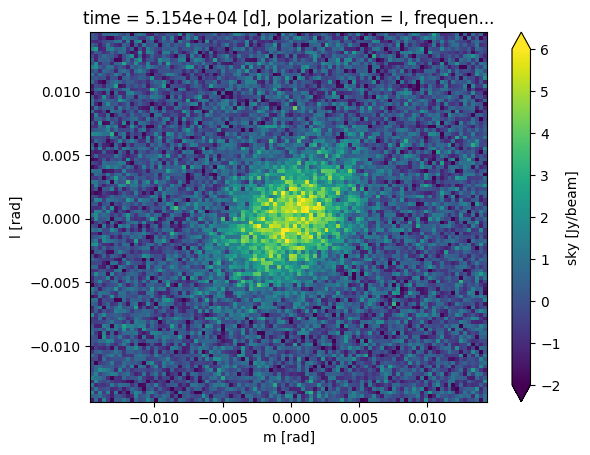

In [54]:
# before region selection, note that we are not using the image pixel mask,
# mask0, for plotting here. This is just a quick and dirty demo; actual
# xradio/ngCASA applications will use pixel masks as expected.
data_sel = {"time": [0], "polarization": [0], "frequency": [0], "l": slice(50, 150)}
clim = {"vmin": -2, "vmax": 6}
xds.sky.isel(data_sel).plot(**clim)

Deliniate a circular region of radius 40 pixels. Pixel values in the region outside the center circle are NaN.

In [55]:
circular_region = xds.copy(deep=True)
l_shift = xds.l - xds.l[len(xds.l) // 2]
m_shift = xds.m - xds.m[len(xds.m) // 2]
radius = 40 * abs(xds.l.cdelt)
circular_region["sky"] = circular_region["sky"].where(l_shift**2 + m_shift**2 <= radius*radius)
circular_region

<xarray.Dataset>
Dimensions:          (time: 1, polarization: 4, frequency: 50, l: 200, m: 100,
                      beam_param: 3)
Coordinates:
  * time             (time) float64 5.154e+04
  * polarization     (polarization) <U1 'I' 'Q' 'U' 'V'
  * frequency        (frequency) float64 1.415e+09 1.415e+09 ... 1.415e+09
    velocity         (frequency) float64 1.146e+06 1.146e+06 ... 1.136e+06
  * l                (l) float64 0.02909 0.0288 0.02851 ... -0.02851 -0.0288
  * m                (m) float64 -0.01454 -0.01425 -0.01396 ... 0.01396 0.01425
    right_ascension  (l, m) float64 0.0291 0.0291 0.0291 ... 6.254 6.254 6.254
    declination      (l, m) float64 -0.01454 -0.01425 ... 0.01396 0.01425
  * beam_param       (beam_param) <U5 'major' 'minor' 'pa'
Data variables:
    sky              (time, polarization, frequency, l, m) float32 dask.array<chunksize=(1, 4, 5, 40, 20), meta=np.ndarray>
    mask0            (time, polarization, frequency, l, m) bool dask.array<chunksize=(1, 4, 5, 40, 20), meta=np.ndarray>
    beam             (time, polarization, frequency, beam_param) float64 dask.array<chunksize=(1, 4, 50, 3), meta=np.ndarray>
Attributes:
    direction:        {'reference': {'frame': 'FK5', 'type': 'sky_coord', 'eq...
    telescope:        {'name': 'ALMA', 'position': {'type': 'position', 'elli...
    obsdate:          {'type': 'time', 'scale': 'UTC', 'units': 'd', 'value':...
    pointing_center:  {'value': array([0., 0.]), 'initial': True}
    observer:         Karl Jansky
    object_name:      SgrB2
    user:             {'phone': 123456}
    active_mask:      mask0
    description:      my way cool pretend image
    history:          <xarray.Dataset>\nDimensions:    (row: 15, TIME: 15, PR...

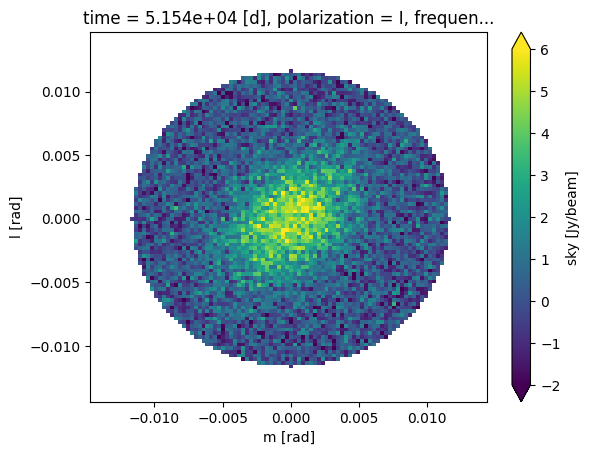

In [56]:
# Here is what the circular region deliniation looks like. Pixel values
# outside the selected region are NaN.
circular_region.sky.isel(data_sel).plot(**clim)

In [57]:
import numpy as np
np.isnan(circular_region.sky.values).all()

False

### Pac Man!
With just a little more effort, a Pac Man region can be created.

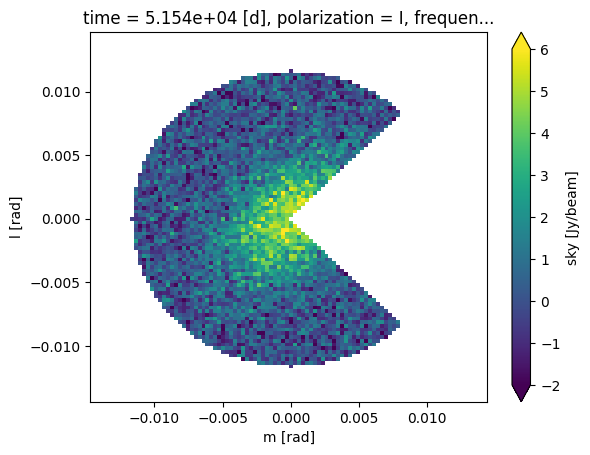

In [58]:
import numpy as np

# just rename the object, no copying is done here
pacman = circular_region
pacman["sky"] = circular_region.sky.where(
    np.logical_or(
        np.logical_or(m_shift < 0, l_shift - m_shift > 0), l_shift + m_shift < 0
    )
)
pacman.sky.isel(data_sel).plot(**clim)

Below in the section on converting an image xds to a CASA image, we will write the pacman xds
to a CASA image and demonstrate that the CASA image pixel values agree with the pacman.sky
array values.

##  Loading Image Data Into Memory
In order to process an image's pixel data, it must be loaded into memory. This data must be immediately loaded, so that it cannot be a Dask array. The general architecture is that the loaded data will be placed in a dask.delayed function for processing.

A loaded data is itself a valid xds image (it can be correctly thought of as a subimage).

In [59]:
subim = load_image(
    "demo_simulated.im",
    block_des={
        "time": 0,
        "polarization": 0,
        "frequency": slice(0, 10),
        "l": slice(40, 80),
        "m": slice(10, 20),
    },
    do_sky_coords=True
)
subim

hello
block_des {'time': [0], 'polarization': [0], 'frequency': slice(0, 10, None), 'l': slice(40, 80, None), 'm': slice(10, 20, None)}


Exception: Unhandled extent type <class 'list'>

#### Loaded data is a numpy array

In [ ]:
subim.sky

In [ ]:
subim.mask0

A numpy.ma.masked_array can be created from the pixels and the mask

In [ ]:
import numpy as np

ma = np.ma.masked_array(subim.sky[:], subim.mask0[:])
ma

#### Loaded data can be used in a dask.delayed function
Now the masked array can be put in a dask.delayed function, and things can be done with it.

In [ ]:
import dask.delayed


def summer(ary):
    return ary.sum()


summer = dask.delayed(summer)(ma)
print(ma.shape)
print("summer type", type(summer))

In [ ]:
mysum = summer.compute()
mysum

## Convert an xds image to a CASA image

In [ ]:
# For this example, arrays are small so force arrays into a single chunk
# so writing doesn't take forever
xds = xds.chunk("auto")
write_image(xds, "new_casa.im", out_format="casa")

In [ ]:
from casacore.images import image as cimage

myim = cimage("new_casa.im")
ia_orig = cimage(imname)

#### Axes order may be different (pol,freq <-> freq, pol), so transpose as necessary
The original image has axes in RA, Dec, Freq, Stokes order. Conversion of an xds image XDS
to a casa image results in a casacore image with axes in the order tclean currently writes,
RA, Dec, Stokes, Freq, so we must transpose the pixel values of one to compare to the pixel
values of the other. And the python-casacore image methods usually access pixels in the
reverse order you would expect.

In [ ]:
(myim.getdata() == ia_orig.getdata().transpose(1, 0, 2, 3)).all()

In [ ]:
got = myim.statistics()
del got["minpos"], got["maxpos"]
exp = ia_orig.statistics()
del exp["minpos"], exp["maxpos"]
for k in exp.keys():
    print(k, np.isclose(got[k][0], exp[k][0]))

In [ ]:
(myim.getmask() == ia_orig.getmask().transpose(1, 0, 2, 3)).all()

In [ ]:
# There is no obvious way to close() an image using
# the python-casacore API, so delete the objects so
# they are removed from the CASA table cache
del myim
del ia_orig

### Write pacman to CASA image

Export the pacman image xds to casa image and plot those pixel data
to verify the sky data and casa image data are the same

In [ ]:
# try/except needed for debugging in case the cell needs
# to be run multiple times, the CASA image must be deleted
# to remove it from the CASA table cache. Just do nothing
# if the CASA image hasn't been created yet.
try:
    del pacman_casa
except NameError as e:
    pass

pacman = pacman.chunk("auto")
write_image(pacman, "pacman.im", "casa")
from casacore.images import image as cimage

pacman_casa = cimage("pacman.im")
pacman_casa_data = pacman_casa.getdata()
import xarray as xr

xr_pacman_casa_data = xr.DataArray(
    pacman_casa_data, dims=["frequency", "polarization", "m", "l"]
)
casa_data_sel = data_sel.copy()
del casa_data_sel["time"]
# note that m and l are swapped relative to the pacman xds, so
# to easily plot  x-axis = l and y-axis = m, transpose
xr_pacman_casa_data = xr_pacman_casa_data.transpose(
    "frequency", "polarization", "l", "m"
)
xr_pacman_casa_data.isel(casa_data_sel).plot(**clim)
del pacman_casa